# Random Forest Classification (RFC)
* SACFOR percent cover for validation
* Headwall Hyperspectral
* aided by: 
https://ceholden.github.io/open-geo-tutorial/python/chapter_5_classification.html

## Import packages

In [ ]:
import os

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio as rio
from rasterio import sample
from rasterio.warp import reproject, Resampling
import rasterio.mask
from rasterio.plot import show

import datetime

from skimage import exposure
from shapely.geometry import box
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.colors import ListedColormap

import contextily as ctx

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, cohen_kappa_score, balanced_accuracy_score
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.preprocessing import MinMaxScaler


from imblearn.ensemble import BalancedRandomForestClassifier

from hyperopt import tpe,hp,Trials
from hyperopt.fmin import fmin

# import xgboost as xgb

### Change working directory

In [952]:
os.chdir('/Users/Meredith/Library/CloudStorage/GoogleDrive-meredith.mcpherson@umb.edu/.shortcut-targets-by-id/1PJamAGTknM_kuVq8M53Xo4cAlWzDOk6I/kelp_murep/rs_imagery_processing/classification/random_forest')

datestring = datetime.datetime.now().date().strftime('%y%m%d')

## Datasets

In [1561]:
# load the sacfor training data shape file
sacfor = gpd.read_file('data/dropcam/gooseberries_sacfor_v2.shp')

# bathymetry tif file
bathy_file = 'data/lidar/2022_ngs_topobathy_chatham_ma_Job964557_reproj.tif'

# rugosity tif file
rug_file = 'data/sidescan/rugosity/Gooseberry_Rugosity_reproj.tif'

# slope tif file
slope_file = 'data/sidescan/slope/Gooseberry_Slope_reproj.tif'

# hyperspectral tif file
img_file = 'data/headwall/nano_Rrs_deglint_smooth_mosaic_mean_v2.tif'

# getis ord spatial auto correlation tif file
gord_file = 'data/headwall/nano_Rrs_deglint_smooth_mosaic_mean_v2_getisord.tif'

# wavelength data
wl = pd.read_csv('data/Headwall/wv_v2.csv', names = ['number','wl'])



## Output Paths

In [1439]:
runtype = 'rrs_getisord'
veg_out = 'output/cross_validation_runs/veg/'
kelp_out = 'output/cross_validation_runs/kelp/'

## Validation GeoDF edit

In [1562]:
sacfor['SACFOR_veg'] = sacfor['SACFOR_veg'].replace('s', 'S')

# Create a new column based on the elevations
z_thresh = -4
sacfor['depth criteria'] = np.where(sacfor['Elev(m)'] >= z_thresh, 'shallow', 'deep')

# create a new column based on presence and absence of kelp via some SACFOR % cover threshold
sacfor['kelp_pres/abs'] = np.where((sacfor['kel #'] == 3)| (sacfor['kel #'] == 4) | (sacfor['kel #'] == 5),1,0)
sacfor['veg_pres/abs'] = np.where((sacfor['veg #'] == 3) | (sacfor['veg #'] == 4) | (sacfor['veg #'] == 5),1,0)
sacfor['veg_corr_pres/abs'] = np.where((sacfor['veg #corr'] == 3) | (sacfor['veg #corr'] == 4) | (sacfor['veg #corr'] == 5),1,0)
# create column to reduce to fewer classes
sacfor['kelp_new_class'] = np.where(sacfor['kel #'].isin([0,1,2,3]), 0, np.where(sacfor['kel #'].isin([4]), 1, np.where(sacfor['kel #'].isin([5]), 2, np.nan)))
sacfor['veg_new_class'] = np.where(sacfor['veg #'].isin([0,1,2,3]), 0, np.where(sacfor['veg #'].isin([4]), 1, np.where(sacfor['veg #'].isin([5]), 2, np.nan)))



Sort sacfor shapefile for NODATA value in image raster

In [1563]:
with rasterio.open(img_file) as src:
    tmp_arr = src.read()

# change the sacfor crs to match image
sacfor = sacfor.to_crs(src.crs)
    
# Create a list to store raster values for each point
raster_values = []

# Loop through each point in the GeoDataFrame
for index, point in sacfor.iterrows():
    
    # Get the coordinates of the point
    x, y = point['geometry'].x, point['geometry'].y

    # Convert point coordinates to pixel coordinates in the raster
    row, col = src.index(x, y)

    # Extract raster value at the pixel coordinates
    try:
        value = tmp_arr[50, row, col]  # Just get one band
    except IndexError:
        value = -9999.0

    # Append the value to the list
    raster_values.append(value)

# Add the extracted values as a new column in the GeoDataFrame
sacfor['spectral value'] = raster_values
sacfor = sacfor[sacfor['spectral value'] != src.nodata]

## Subset and mask deep water in the Headwall imagery

1. Crop the bathymetry file to the headwall bounding box
2. Crop the sacfor shapefile to the headwall bounding box
3. Mask deeper than the chosen depth threshold
4. Crop everything to the smaller subset area in north gooseberries

In [1564]:
# Define the bounding box to crop to (xmin, ymin, xmax, ymax)

# CRS.from_epsg(26986)
# gb_subset_bbox = [258025, 919500, 258150, 919650]


# CRS.from_epsg(32619)
# gb_subset_bbox = [352664.3381461279, 4709500.633945491, 352793.6858460658, 4709654.231824983]

# NS flight lines
gb_subset_bbox = [src.bounds[0],src.bounds[1],352855,src.bounds[3]]

In [1565]:
# Crop and mask everything

# Load the hyperspectral data 
with rio.open(img_file) as src:
    arr = src.read()
    arr_nanmasked = src.read(masked=True)
    
    meta = src.meta
    
    # HEADWALL BBOX
    # get the bounding corners and create window for the headwall src
    headwall_bbox = src.bounds
    headwall_bbox = [headwall_bbox.left, 
                     headwall_bbox.bottom, 
                     headwall_bbox.right, 
                     headwall_bbox.top]

    headwall_window = rio.windows.from_bounds(*headwall_bbox, 
                                              transform=meta['transform'])
        
    # convert the sacfor dataframe to the hyperspectral crs
    sacfor = sacfor.to_crs(src.crs)
    
    # crop sacfor to headwall bbox
    sacfor_headwall = sacfor[sacfor.within(box(*headwall_bbox))]
    
    # Open the reprojected file in read mode and read the data
    with rio.open(bathy_file) as bathy:
        bathy_arr = bathy.read(1,masked=True)

        # filter data greater than 0
        bathy_arr[bathy_arr >= 0] = src.nodata
        # filter where image is nodata
        bathy_arr[arr[50,:,:] == src.nodata] = src.nodata

        # create the mask from nodata values
        bathy_arr_mask = bathy_arr == src.nodata
        # mask the array
        bathy_arr_nanmask = np.ma.masked_array(bathy_arr,
                                               bathy_arr_mask)

        # open getis ord 
        with rio.open(gord_file) as gstar:
            gstar_arr = gstar.read(masked=True)
            gstar_arr_nanmasked = np.ma.masked_array(gstar_arr,
                                                     mask = np.tile(bathy_arr_mask, (arr.shape[0], 1, 1)))
            # open slope
            with rio.open(slope_file) as slope:
                slope_arr = slope.read(1,masked=True)
                slope_arr_nanmasked = np.ma.masked_array(slope_arr,
                                                         bathy_arr_mask)

                # open rugosity
                with rio.open(rug_file) as rug:
                    rug_arr = rug.read(1,masked=True)
                    rug_arr_nanmasked = np.ma.masked_array(rug_arr,
                                                           bathy_arr_mask)
                    
                    
                    # check bounds to see if they match with imagery
                    if (src.bounds == bathy.bounds == slope.bounds == rug.bounds) == False:
    
                        # crop the bathymetry data to the headwall bbox
                        bathy_headwall = bathy.read(window=headwall_window)[0]
    
                        slope_headwall = slope.read(window==headwall_window)[0]
                        
                        rug_headwall = rug.read(window==headwall_window)[0]

                        gstar_headwall = gstar.read(window==headwall_window_[0])
    
                        # Mask the headwall array where the values are greater than -4 or nan
                        nanmask = bathy_headwall == src.nodata
                        arr_nanmasked = np.ma.masked_array(arr, 
                                                           mask=np.tile(nanmask, (arr.shape[0], 1, 1)))
    
                        zmask = bathy_arr < z_thresh
                        arr_zmasked = np.ma.masked_array(arr_nanmasked, 
                                                         mask=np.tile(zmask, (arr.shape[0], 1, 1)))
    
                    else:
                        # ----- SUBSET BBOX
                        # create window for subset
                        subset_window = rio.windows.from_bounds(*gb_subset_bbox, 
                                                                transform=meta['transform'])
    
                        # crop the headwall array to the subset bbox
                        arr_subset = src.read(window=subset_window)
    
                        # crop the bathymetry data to the subset bbox
                        bathy_subset = bathy.read(window=subset_window)[0]
                        # align all nodata values
                        bathy_subset[bathy_subset == bathy.nodata]= src.nodata
                        bathy_subset[bathy_subset >= 0] = src.nodata
                        bathy_subset[arr_subset[50,:,:] == src.nodata] = src.nodata
    
                        # crop the slope data to the subset bbox
                        slope_subset = slope.read(window=subset_window)[0]
                        # # align all nodata values
                        slope_subset[slope_subset == slope.nodata]= src.nodata
                        slope_subset[arr_subset[50,:,:] == src.nodata] = src.nodata
                        
                        
                        # crop the rugosity data to the subset bbox
                        rug_subset = rug.read(window=subset_window)[0]
                        # # align all nodata values
                        rug_subset[rug_subset == rug.nodata]= src.nodata
                        rug_subset[arr_subset[50,:,:] == src.nodata] = src.nodata
                        
                        # crop the getisord data to the subset bbox
                        gstar_subset = gstar.read(window=subset_window)
                        # gstar_subset[gstar_subset == gstar_subset.nodata] = src.nodata
                        # gstar_subset[arr_subset[50,:,:] == src.nodata] = src.nodata
                        
                        # Filter sacfor points within the subset bounding box
                        sacfor_subset = sacfor[sacfor.within(box(*gb_subset_bbox))]
    
                        # sort out deep elevation in SACFOR
                        sacfor_subset_filt = sacfor_subset[sacfor_subset['Elev(m)']>=z_thresh]

                        
                        # Nanmask all the subset arrays 
                        nanmask = bathy_subset == src.nodata
                        arr_subset_nanmasked = np.ma.masked_array(arr_subset,
                                                                  mask=np.tile(nanmask, (arr_subset.shape[0], 1, 1)))

                        gstar_subset_nanmasked = np.ma.masked_array(gstar_subset,
                                                                    mask = np.tile(nanmask, (arr_subset.shape[0], 1, 1)))
                        
                        bathy_subset_nanmasked = np.ma.masked_array(bathy_subset, 
                                                                    mask=nanmask)
                        
                        nanmask_slope = slope_subset == src.nodata
                        slope_subset_nanmasked = np.ma.masked_array(slope_subset, 
                                                                    mask=nanmask_slope)
                        
                        nanmask_rug = rug_subset == src.nodata
                        rug_subset_nanmasked = np.ma.masked_array(rug_subset, 
                                                                  mask=nanmask_rug)

                        
                        # Mask the subset array where the values are greater than -4
                        zmask = bathy_subset < z_thresh
                        arr_subset_zmasked = np.ma.masked_array(arr_subset_nanmasked, 
                                                                mask=np.tile(zmask, 
                                                                             (arr_subset.shape[0], 1, 1)))
                        bathy_subset_zmasked = np.ma.masked_array(bathy_subset_nanmasked,
                                                                  mask = zmask)
                        
                        slope_subset_zmasked = np.ma.masked_array(slope_subset_nanmasked,
                                                                  mask = zmask)
                        rug_subset_zmasked = np.ma.masked_array(rug_subset_nanmasked,
                                                                mask = zmask)

##### Save the raster

In [ ]:
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

outfile = img_file[:-4]+'_NS.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(arr_subset_nanmasked)

with rio.open(outfile) as data:
    d = data.read(masked=True)

plt.imshow(d[10,:,:])
plt.colorbar()

#### Rasterize the SACFOR for RF runs

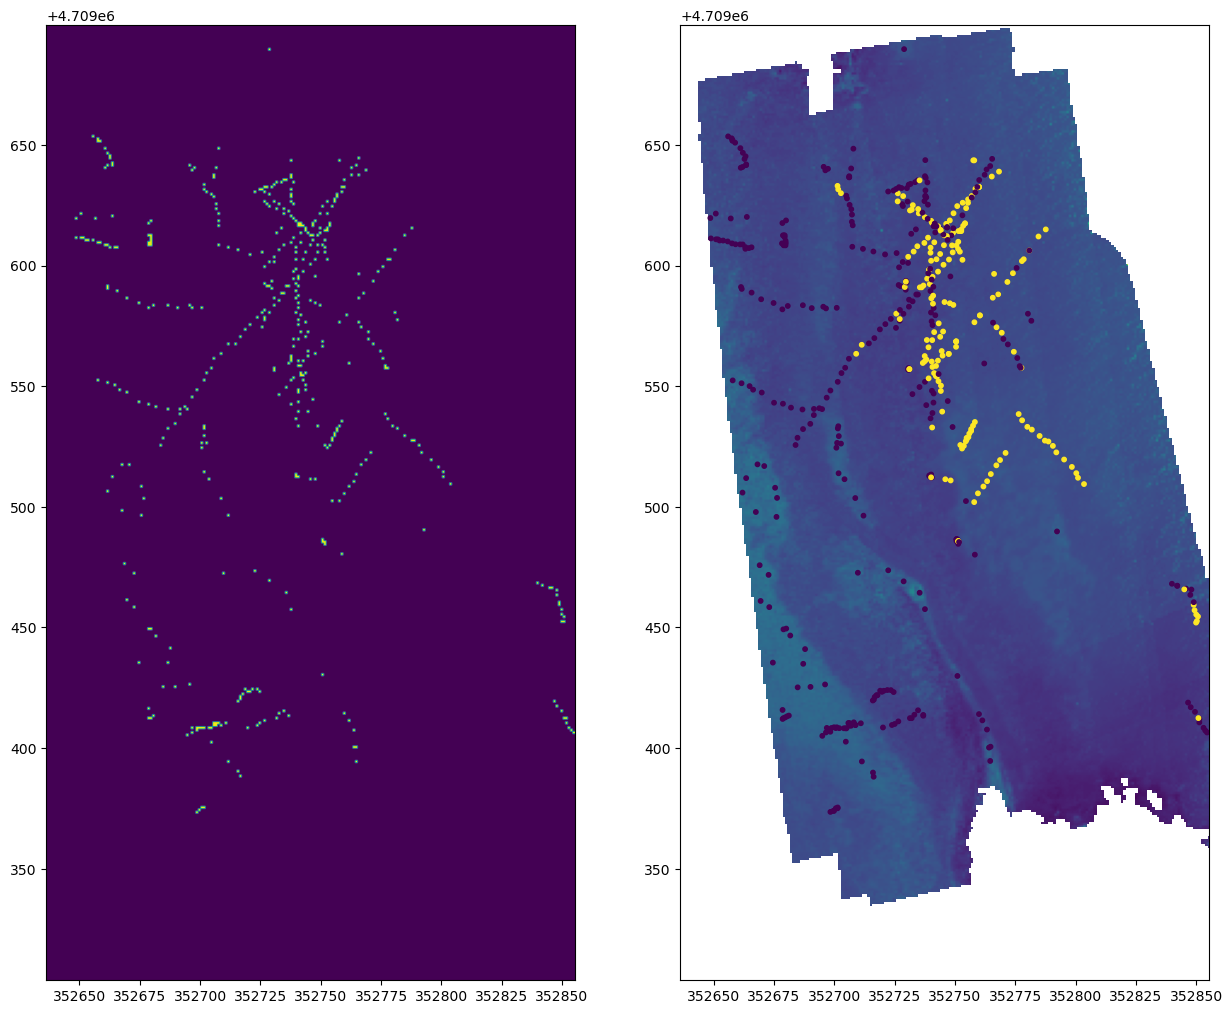

In [1566]:
# rasterize the sacfor gpd to the cropped bounding box based on the 'sacfor_veg target
# as the values in the sacfor raster
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "dtype": 'int32'
})


# updated sacfor file with bathymetry from Lidar data
file = 'data/dropcam/gooseberries_sacfor_v2_subset_v2.shp'
sacfor_data = gpd.read_file(file)

# sacfor_data = sacfor_data[sacfor_data['Elev(m)']>=z_thresh]

# Names
sacfor_raster_names = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data.index)],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

# BINARY SACFOR 
sacfor_raster_binveg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['veg_pres/a'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_binkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_pres/'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


# COMBINED SACFOR CLASSES
sacfor_raster_fewveg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['veg_new_cl'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_fewkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_new_c'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


# FULL SACFOR 
sacfor_raster_veg = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['veg #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

sacfor_raster_kelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kel #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-999.0,
    all_touched=True,
    dtype='int32'
)

# Check transforms match up

fig1, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,15))
     
show(sacfor_raster_names,
     transform = out_meta['transform'],
              ax=ax1)
# s = sacfor_subset.plot(ax=ax1, 
#                             column='kelp_new_class', 
#                             markersize = 10,
#                            edgecolor='k')
                            

show(arr_subset_nanmasked[50,:,:],
     transform = out_meta['transform'],
              ax=ax2)
s = sacfor_data.plot(ax=ax2, 
            column='kelp_pres/', 
            markersize = 10)


#### Figure for entire Gooseberry Headwall area with SACFOR overlayed

In [ ]:
# import shapefile for mass coastline
# mass coastline shapefile
mass = gpd.read_file('/Users/Meredith/Desktop/massgis-coast25k-arc-shapefile/GISDATA_COAST25K_ARC.shp')
mass = mass.to_crs(src.crs)
mass.plot()

# Create a bounding box from the raster bounds
bbox = src.bounds

# Subset the coastline to the extent of the raster
mass_subset = mass.cx[bbox.left:bbox.right, bbox.bottom:bbox.top]

mass_subset.plot()

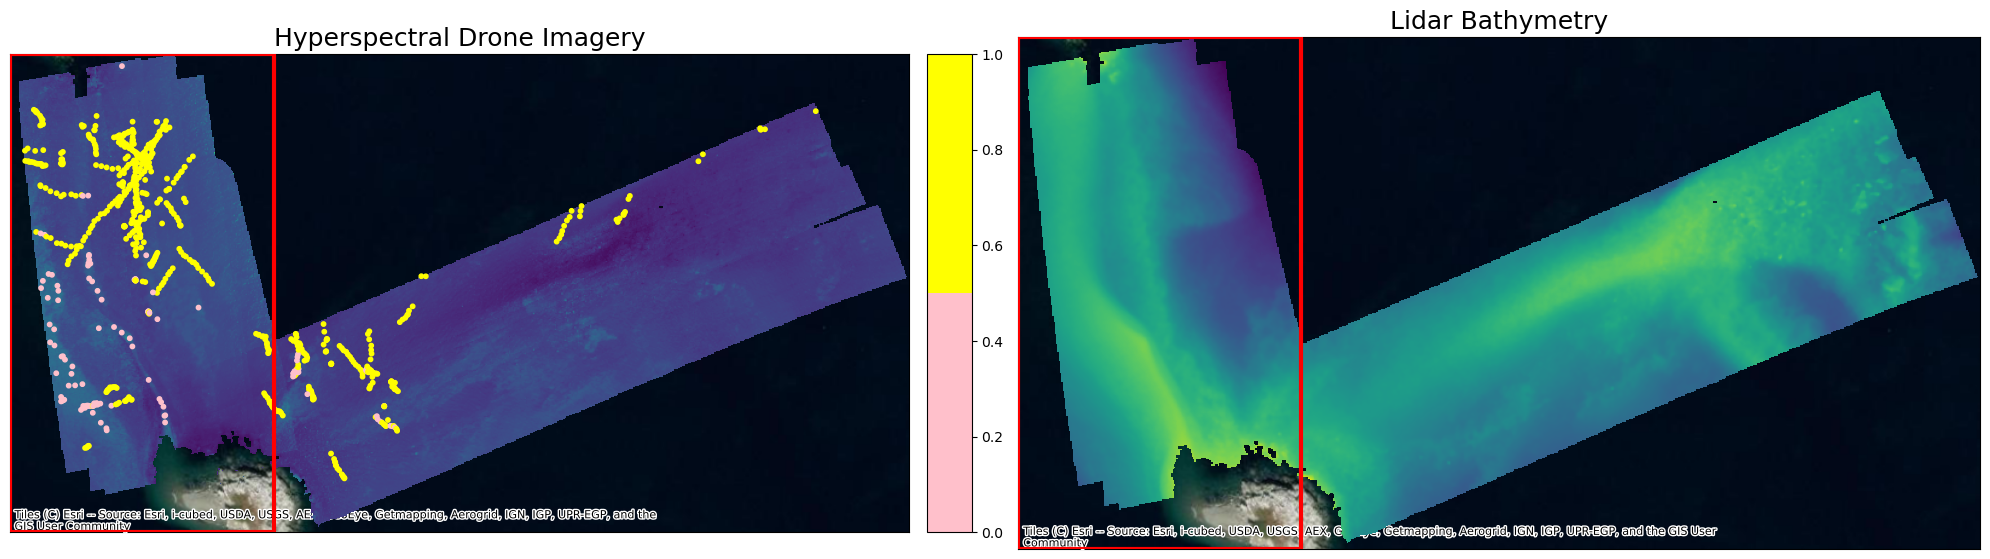

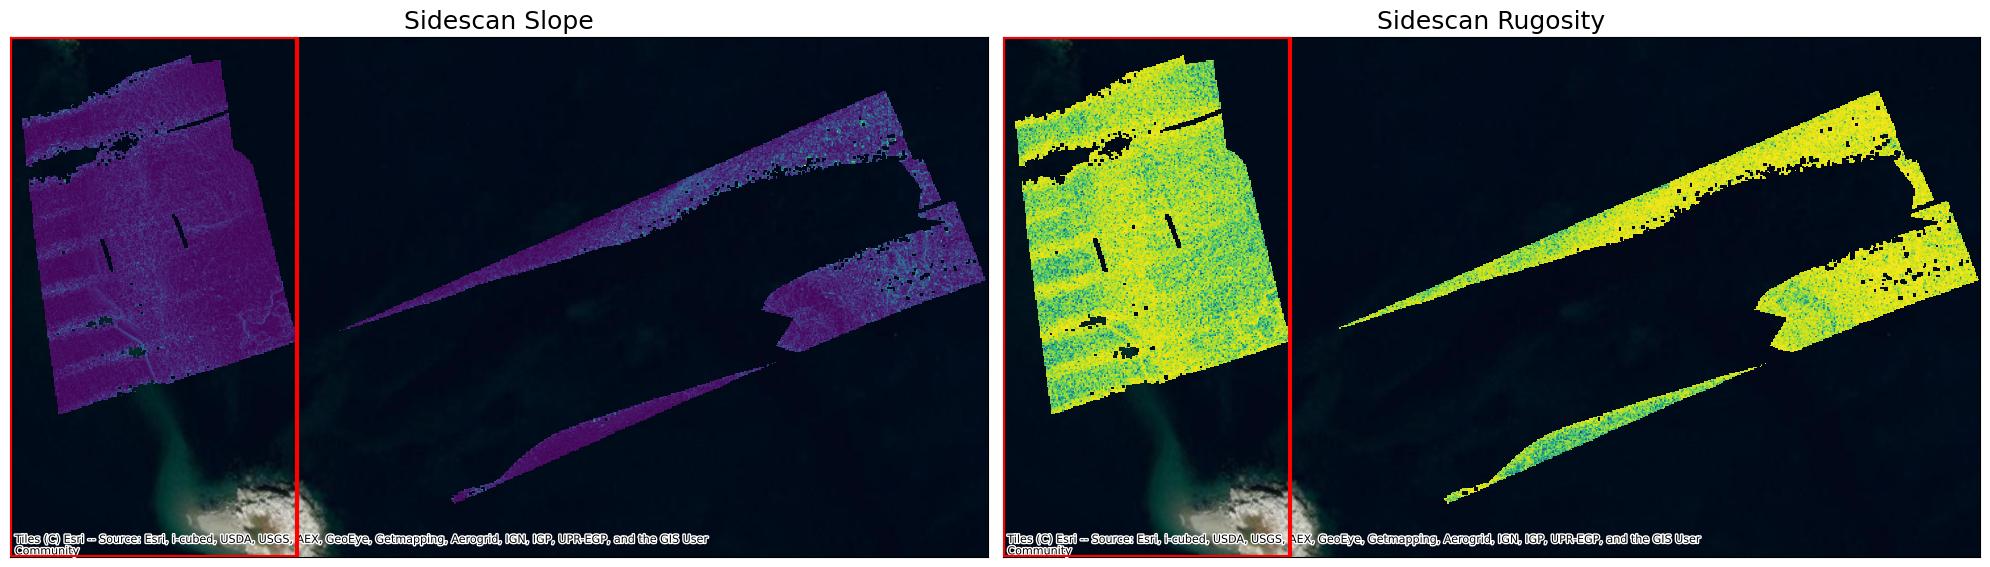

In [995]:
# create RGB


corr_rgb = arr[[120, 70, 25], :, :]
corr_rgb[corr_rgb < 0] = np.nan

# Apply contrast stretching to improve the visibility
# stretched = np.zeros_like(corr_rgb)
# for i in range(3):
#     stretched[i] = exposure.rescale_intensity(corr_rgb[i])

# adjust the brightness of the image

gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)


# Plot the figure
fig1, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 20))

# rgb + sacfor

# rgb_im = show(gamma_corrected, 
#      transform = rio.windows.transform(headwall_window, src.transform),
#      ax=ax2)
rgb_im = show(arr_nanmasked[50,:,:], 
             transform = rio.windows.transform(headwall_window, src.transform),
              zorder=10,
             ax=ax1)
im = rgb_im.get_images()[0]

# sacfor colorbar
# Define the colors for 0 and 1
colors = ['pink', 'yellow']

# Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')

s = sacfor_headwall.plot(ax=ax1, 
                           column='veg_pres/abs', 
                           markersize=10,
                            legend = True,
                            cax=cax,
                         zorder=21,
                            #legend_kwds={"label": "Vegetation", "orientation": "vertical"},
                           cmap = cmap)

ax1.set_title(f'Hyperspectral Drone Imagery',
              fontsize=18)# < {z_thresh} m')


rect2 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                          edgecolor='r', 
                          facecolor='none',
                          zorder=21)

ax1.add_patch(rect2)

ctx.add_basemap(ax1, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)
ax2.set_xticks([])
ax2.set_yticks([])


# bathymetry
# Overlay the red box
rect1 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                          edgecolor='r', 
                          facecolor='none',
                          zorder=21)
ax2.add_patch(rect1)




rio_im = show(bathy_arr_nanmask,
              transform = rio.windows.transform(headwall_window, bathy.transform),
              cmap='viridis',
              zorder=10,
              ax=ax2)
im = rio_im.get_images()[0]

ax2.set_title('Lidar Bathymetry', 
              fontsize = 18)
ctx.add_basemap(ax2, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)
ax1.set_xticks([])
ax1.set_yticks([])

# divider = make_axes_locatable(ax1)
# cax1 = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar1 = fig1.colorbar(im, cax=cax1)
# cbar1.set_label('Elevation (m)')


fig1.tight_layout()
# fig1.savefig('output/figs/headwall_bathy_rasters.png',dpi=300)
plt.show()



#######################
# Figure 2
#######################

fig2, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20, 20))
# Overlay the red box on the hyperspectral subplot
rect1 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                        edgecolor='r', 
                          facecolor='none',
                          zorder=21)
ax1.add_patch(rect1)

# slope

rio_im = show(slope_arr_nanmasked,
              transform = rio.windows.transform(headwall_window, bathy.transform),
              cmap='viridis',
              zorder=10,
              ax=ax1)
im = rio_im.get_images()[0]

ax1.set_title(f'Sidescan Slope',
              fontsize=18)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar2 = fig2.colorbar(im, cax=cax)
# cbar2.set_label(f'Slope ({chr(176)})')

ctx.add_basemap(ax1, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)
ax1.set_xticks([])
ax1.set_yticks([])

###### rugosity

# Overlay the red box on the hyperspectral subplot
rect1 = patches.Rectangle((gb_subset_bbox[0], gb_subset_bbox[1]), gb_subset_bbox[2] - gb_subset_bbox[0], gb_subset_bbox[3] - gb_subset_bbox[1],
                         linewidth=3, 
                          edgecolor='r', 
                          facecolor='none',
                          zorder=21)
ax2.add_patch(rect1)

rio_im = show(rug_arr_nanmasked,
              transform = rio.windows.transform(headwall_window, bathy.transform),
              cmap='viridis',
              zorder=10,
              ax=ax2)
im = rio_im.get_images()[0]

ax2.set_title(f'Sidescan Rugosity',
              fontsize=18)

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar3 = fig2.colorbar(im, cax=cax)
# cbar3.set_label(f'Rugosity')

ctx.add_basemap(ax2, crs=sacfor_headwall.crs, source=ctx.providers.Esri.WorldImagery)

ax2.set_xticks([])
ax2.set_yticks([])

# tight layout and save
fig2.tight_layout()
# fig2.savefig('output/figs/slope_rugosity_rasters.png',dpi=300)
plt.show()

#### Figure for subset of Gooseberry Headwall area

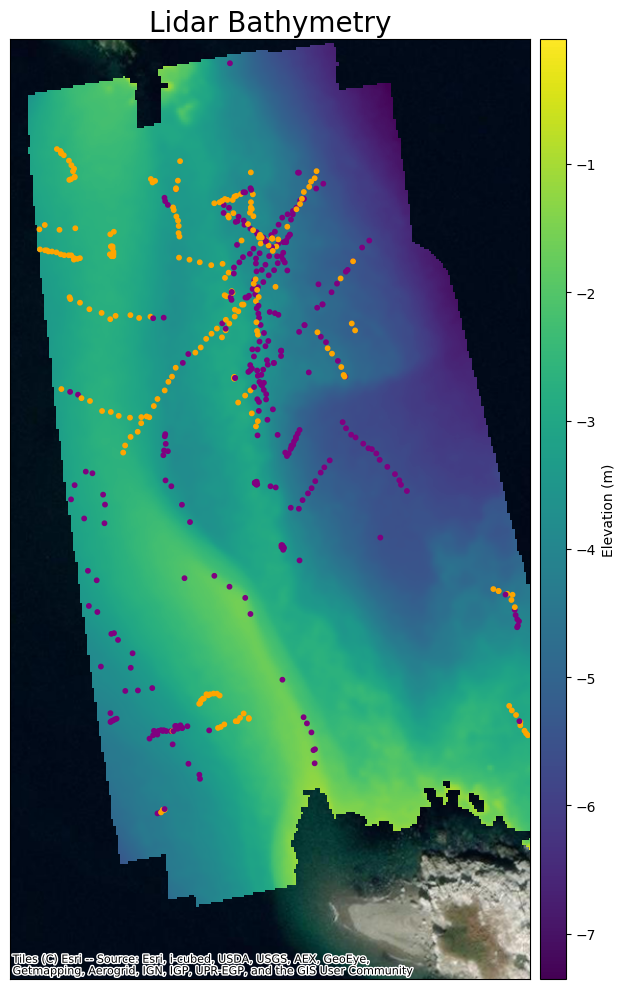

In [996]:
# create RGB

# full spectral resolution 
corr_rgb = arr_subset_nanmasked[[114, 75, 25], :, :]


# Apply contrast stretching to improve the visibility
# stretched = np.zeros_like(corr_rgb)
# for i in range(3):
#     stretched[i] = exposure.rescale_intensity(corr_rgb[i])

# adjust the brightness of the image

gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

fig2, (ax1) = plt.subplots(ncols=1, figsize=(10, 10))

# bathymetry
rio_im = show(bathy_subset_nanmasked, 
              transform = rio.windows.transform(subset_window, bathy.transform), 
              ax=ax1,
              cmap='viridis',
             zorder=10)
im = rio_im.get_images()[0]
ax1.set_title('Lidar Bathymetry',fontsize=20)
ax1.set_xticks([])
ax1.set_yticks([])


# bathymetry colorbar

divider = make_axes_locatable(ax1)
cax1 = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')
cbar1 = fig1.colorbar(im, cax=cax1)
cbar1.set_label('Elevation (m)')

# Define the colors for 0 and 1
colors = ['purple', 'orange']

# # Create a ListedColormap with the specified colors
cmap = ListedColormap(colors)

# divider = make_axes_locatable(ax1)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# cbar = fig1.colorbar(im, 
#                      cax=cax)
# cbar.set_label('Elevation (m)')
s = sacfor_subset.plot(ax=ax1, 
                        column='veg_corr_pres/abs', 
                        markersize=10,
                        # legend = True,
                        # cax=cax,
                       # legend_kwds={"label": "Kelp", "orientation": "vertical"},
                        cmap = cmap,
                      zorder=11)
# Add a basemap using contextily
# ctx.add_basemap(ax1, crs=sacfor_subset.crs, source=ctx.providers.CartoDB.Positron)
ctx.add_basemap(ax1, crs=sacfor_subset.crs, source=ctx.providers.Esri.WorldImagery)



# rgb + sacfor plot
# rgb_im = show(gamma_corrected, 
#               transform = rio.windows.transform(subset_window, src.transform), 
#               ax=ax2)
# rgb_im = show(arr_subset[50,:,:], 
#               transform = rio.windows.transform(subset_window, src.transform), 
#               ax=ax2)
# im = rgb_im.get_images()[0]

# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad='2%')
# s = sacfor_subset.plot(ax=ax2, 
#                            column='kelp_pres/abs', 
#                            markersize=10,
#                             legend = True,
#                             cax=cax,
#                             legend_kwds={"label": "Kelp Pres/Abs", "orientation": "vertical"},
#                            cmap = 'viridis')


# ax2.set_title(f'Headwall RGB < {z_thresh} m')

# ax2.set_xticks([])
# ax2.set_yticks([])

fig2.tight_layout()
# fig2.savefig('output/figs/bathy_with_veg.png',dpi=300)
plt.show()


## Vegetation Classifier

### Dimensionality Reduction - PCA on Headwall 

In [1349]:

# stack the bathymetry and imagery arrays before flattening
bathy_reshape = np.reshape(bathy_subset_nanmasked,(1,bathy_subset_nanmasked.shape[0],bathy_subset_nanmasked.shape[1]))
arr_clean = np.ma.vstack((arr_subset_nanmasked,gstar_subset_nanmasked,bathy_reshape))
# arr_clean = arr_subset_nanmasked

# Convert to 2D numpy array
flattened_data = np.transpose(arr_clean, (1, 2, 0)).reshape(-1, arr_clean.shape[0])

# add bathymetry data onto flattened data

# Perform PCA on the flattened data
pca = PCA(n_components = 50)
pca.fit(flattened_data)

# Transform the data into the PCA space
pca_data_flattened = pca.transform(flattened_data)

# Reshape the PCA data back into its original shape
pca_data = pca_data_flattened.reshape(arr_clean.shape[1], arr_clean.shape[2],-1)

#arr_clean_pca = arr_clean.reshape(arr_clean.shape[1], arr_clean.shape[2],arr_clean.shape[0])
arr_clean_nopca = np.transpose(arr_clean, (1, 2, 0))

# # Save the PCA data to disk
# with rio.open(pca_file, 'w', **meta) as dst:
#     dst.write(pca_data)


### Setting up data - Pairing X and y data

In [1350]:
sacfor_type = sacfor_raster_binveg

n_samples = (sacfor_type >= 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sacfor_type[sacfor_type >= 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))

# get the spectra and depth to put into the model
predictors = arr_clean_nopca[sacfor_type >= 0,:]
# predictors = pca_data[sacfor_type >= 0,:]

# We will need a "X" matrix containing our features, and a "y" array containing our labels
# These will have n_samples rows
X = predictors

# X with pca only 
# X = pca_data[sacfor_type >= 0,:]

# y
# y = sacfor_type[sacfor_type >= 0]

# y removing NaN from depth
y = sacfor_type[sacfor_type >= 0]#[~np.isnan(X).any(axis=1)]

# get the ID for the names so that it can be added to a results df later
names = sacfor_raster_names[sacfor_type >= 0]#[~np.isnan(X).any(axis=1)]

# # scale X
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# split up the dataset to training and validation with stratification
train_X, val_X, train_y, val_y, train_names, val_names = train_test_split(
    X, y, names,
    test_size=0.2,
    random_state=1,
    stratify=y  # Ensure stratified split based on 'y'
)


print('Our X matrix is sized: {sz}'.format(sz=X.shape))
print('Our y array is sized: {sz}'.format(sz=y.shape))

We have 472 samples
The training data include 2 classes: [0 1]
Our X matrix is sized: (472, 363)
Our y array is sized: (472,)


### K-folds Cross Validation Balanced Random Forest Classifier

In [ ]:
# Initialize lists to store results
accuracy_scores = []
balanced_accuracy_scores = []
kappa_scores = []
mean_squared_errors = []

# times to repeat k-fold
splits = 5
k_times = 10
tot_runs = splits*k_times

veg_pred = np.ma.masked_array(np.zeros((tot_runs,arr_clean.shape[1],arr_clean.shape[2])),
                              mask = np.tile(nanmask, (tot_runs, 1, 1)))

# Define k-fold cross-validation
k_fold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Repeat 10 times
for k in range(k_times):
    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(k_fold.split(train_X)):
        # Fit model
        rf = BalancedRandomForestClassifier(bootstrap=True)
        rf.fit(train_X[train_index], train_y[train_index])
        
        # Predict on validation set
        y_pred_rf = rf.predict(train_X[val_index])
        
        # Calculate metrics
        acc_score = accuracy_score(train_y[val_index], y_pred_rf) * 100
        bacc_score = balanced_accuracy_score(train_y[val_index], y_pred_rf) * 100
        k_score = cohen_kappa_score(train_y[val_index], y_pred_rf)
        mse = mean_squared_error(train_y[val_index], y_pred_rf)

        # populate lists
        accuracy_scores.append(acc_score)
        balanced_accuracy_scores.append(bacc_score)
        kappa_scores.append(k_score)
        mean_squared_errors.append(mse)

        # predict the class for each pixel
        pred = rf.predict(flattened_data)
        # pred = rf.predict(pca_data_flattened)
        
        pred_reshape = pred.reshape(arr_clean[0,:, :].shape)
        pred_mask = np.ma.masked_array(pred_reshape, mask=np.tile(nanmask, (1, 1, 1)))

        # Save predictions to veg_pred
        start_index = k * splits
        # end_index = (k + 1) * splits
        # veg_pred[start_index:end_index, :, :] = pred_mask
        veg_pred[start_index+i, :, :] = pred_mask

        # plot a figure for each k-fold run
        
        fig,(ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
        # Cross-tabulate predictions
        cm = ConfusionMatrixDisplay.from_estimator(rf, val_X, val_y,ax=ax1,colorbar=False)
        cm.ax_.set_title(f'Balanced Accuracy Score: {bacc_score:.1f}%'+f'\nMSE: {mse:.2f}')
        
        ax2.imshow(pred_mask,cmap='tab20b')

        # fig.savefig(f'{veg_out}kfold_runs/{runtype}/rrs_gord_z/{datestring}_PA_BRFconfusion_kfold_run{start_index+i+1}.png')
        plt.show()
        


In [1353]:
# Print average results from k-fold cross validation runs
mean_acc = sum(accuracy_scores) / len(accuracy_scores)
mean_bacc = sum(balanced_accuracy_scores) / len(balanced_accuracy_scores)
mean_kappa = sum(kappa_scores) / len(kappa_scores)
mean_mse = sum(mean_squared_errors) / len(mean_squared_errors)

print(f'Average Accuracy Score: {mean_acc:.2f}%')
print(f'Average Balanced Accuracy Score: {mean_bacc:.2f}%')
print(f'Average Kappa Score: {mean_kappa:.2f}')
print(f'Average MSE: {mean_mse:.2f}')

Average Accuracy Score: 95.51%
Average Balanced Accuracy Score: 92.82%
Average Kappa Score: 0.84
Average MSE: 0.04


#### Final maps

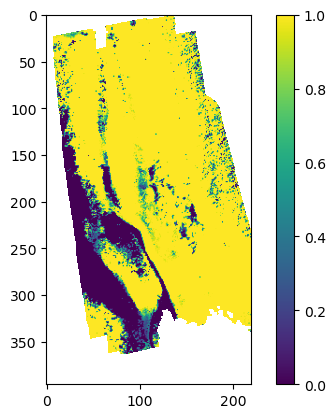

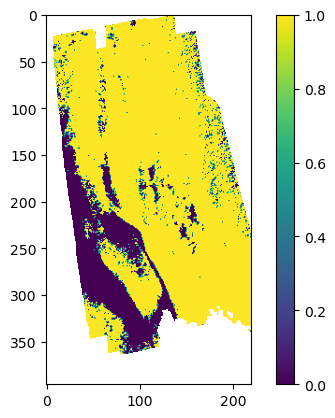

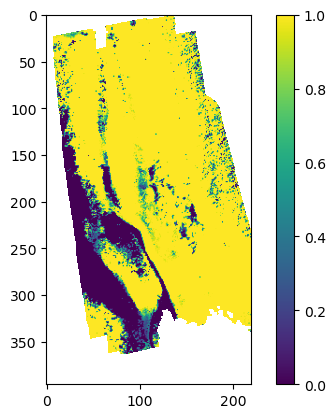

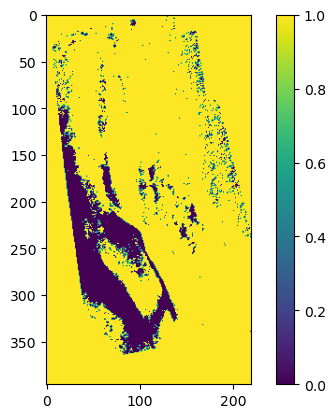

In [1354]:

# Calculate Probability
prob_veg = sum(veg_pred)/tot_runs
prob_veg = prob_veg.reshape(1, prob_veg.shape[0],prob_veg.shape[1])
plt.imshow(prob_veg[0,:,:])
plt.colorbar()
plt.show()

# Calculate Classification
pa_veg = prob_veg > 0.5
plt.imshow(pa_veg[0,:,:])
plt.colorbar()
plt.show()

# set the metadata for the rasters
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "count": 1,
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

# save probability raster
outname = 'getisord_z_veg_probability.tif'
# outfile = veg_out + f'final_maps/{runtype}/getisord_z/final_veg_probability.tif'
outfile = f'output/cross_validation_runs/veg/final_maps/getisord/{outname}'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(prob_veg)

with rio.open(outfile) as data:
    d = data.read(masked=True)

plt.imshow(d[0,:,:])
plt.colorbar()
plt.show()


# save presence/absence raster
outname = 'getisord_z_veg_classification.tif'
# outfile = veg_out + f'final_maps/{runtype}/getisord_z/final_veg_classification.tif'
outfile = f'output/cross_validation_runs/veg/final_maps/{runtype}/{outname}'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(pa_veg)

with rio.open(outfile) as data:
    d = data.read(masked=True)

plt.imshow(d[0,:,:])
plt.colorbar()
plt.show()


#### Characterizing misclassified spectra

In [ ]:
# Create a DataFrame with true labels, predicted labels, and features
results_df = pd.DataFrame({
    'Name': sacfor_data['Name'][val_names.tolist()],
    'True_Label': val_y,
    'Predicted_Label': y_pred_rf,
     'Depth': val_X[:, -1]
    # Add other features if needed
})

# Add a column indicating whether the prediction was correct
results_df['Correctly_Classified'] = results_df['True_Label'] == results_df['Predicted_Label']
results_df['Label_Difference'] = results_df['True_Label'] - results_df['Predicted_Label']
results_df.reset_index(inplace=True)

results_df.to_csv(f'output/{datestring}_veg_PA.csv')

num_classes = 2
label = ['Absence','Presence']
# label = ['Low', 'Medium', 'Dense']

# Create a 3x3 grid for subplots
fig, axes = plt.subplots(num_classes, 3, figsize=(15, 5 * num_classes))

# create a ScalarMappable object for the color mapping
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=sacfor_data['Elev(m)'].min(), vmax=sacfor_data['Elev(m)'].max())

for val in range(num_classes):
    print(val)
    
    # Extract indices of correctly and incorrectly classified samples
    correct_indices = results_df[(results_df['True_Label'] == val) & (results_df['Correctly_Classified']==True)].index
    incorrect_indices = results_df[(results_df['True_Label'] == val) & (results_df['Correctly_Classified']==False)].index
    
    # Access corresponding features for correctly and incorrectly classified samples
    correctly_classified = val_X[correct_indices].T[:-1]
    incorrectly_classified = val_X[incorrect_indices].T[:-1]
    incorrectly_classified_val = results_df['Label_Difference'][incorrect_indices]
    depth = results_df['Depth'][correct_indices]
    
    correctly_classified_mean = np.mean(correctly_classified,axis=1)
    incorrectly_classified_mean = np.mean(incorrectly_classified,axis=1)

    '''
    plot it in a grid for each class where each row has three columns with 
    1. the correctly classified spectra (no color specification) 
    
    2. the incorrectly classified spectra (shade is based on sign value, 
    color is based on magnitude)
    
    3. the mean of the correctly and incorrectly labeled spectra (black solid for correct, 
    black dashed for incorrect)
    
    '''
    
    # Plotting the correctly classified spectra
    for e,el in enumerate(depth):
        axes[val, 0].plot(wl['wl'], correctly_classified[:,e], linewidth = 1,color=cmap(norm(el)))
    #axes[val, 0].plot(wl['wl'],correctly_classified,color=cmap(norm(depth)))
    axes[val, 0].set_title(f'Correctly Classified: {label[val]}')
    # axes[val, 0].set_ylim([0,0.015])
    axes[val, 0].set_xlabel('Wavelength (nm)')
    axes[val, 0].set_ylabel('Rrs (sr-1)')

    # Plotting the incorrectly classified spectra
    axes[val, 1].plot(wl['wl'],incorrectly_classified, color=cmap(norm(el)))
    
    # Customize line colors based on 'incorrectly_classified_val' sign
    for l,line in enumerate(axes[val, 1].lines):
        if incorrectly_classified_val.iloc[l] < 0:
            line.set_linestyle(':')
        else:
            line.set_linestyle('-')
    
    # update plot settings        
    axes[val, 1].set_title(f'Incorrectly Classified: {label[val]}')
    # axes[val, 1].set_ylim([0,0.015])
    axes[val, 1].set_xlabel('Wavelength (nm)')
    axes[val, 1].set_ylabel('Rrs (sr-1)')
    #axes[val, 1].legend(['overclassified','underclassified'])

    # Plotting the mean of correctly and incorrectly labeled spectra
    axes[val, 2].plot(wl['wl'],correctly_classified_mean, label='Correctly Classified',color='k')
    axes[val, 2].plot(wl['wl'],incorrectly_classified_mean, label='Incorrectly Classified',color='k',linestyle=':')
    # axes[val, 2].set_ylim([0,0.015])
    axes[val, 2].set_xlabel('Wavelength (nm)')
    axes[val, 2].set_ylabel('Rrs (sr-1)')
    axes[val, 2].set_title(f'Mean Spectra: {label[val]}')
    axes[val, 2].legend()

# add the colorbar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([1, 0.1, 0.03, 0.8])
cb1 = mpl.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation='vertical')
cb1.set_label('Elevation (m)',fontsize=18)
cbar_ax.tick_params(labelsize=18)  

plt.tight_layout()
plt.show()
    
fig.savefig(f'output/veg/{datestring}_veg_BRF_PA_spectra.png')    

#### Band Importance

In [ ]:
# band importance
bands = list(range(1, arr_clean_nopca.shape[2]))
importance = rf.feature_importances_

# for b, imp in zip(bands, importance):
#     print('Band {b} importance: {imp}'.format(b=b, imp=imp))

# create a dataframe with wl and importance together
# wl.loc[-1] = ['z',1]

impt = pd.DataFrame(columns = ['wl','importance'])
impt['wl'] = wl['wl']
impt['importance'] = importance[:-1]

n_largest_values = impt['importance'].nlargest(10)
top_wl = impt.loc[n_largest_values.index]['wl']

# plot band imporance
fig,(ax1) = plt.subplots()
# ax1.plot(new_wl['wl'],arr_clean[:,80,60])
# ax1.plot(new_wl['wl'],arr_clean[:,80,60])
# ax1_twin = ax1.twinx()
ax1.plot(impt.wl,impt.importance,c='r')
ax1.set_ylabel('Importance')
# ax1_twin.set_ylabel('Band Importance')
ax1.set_xlabel('Wavelength')
fig.tight_layout()

### Predicting Vegetation the rest of the image

Plot the classification raster

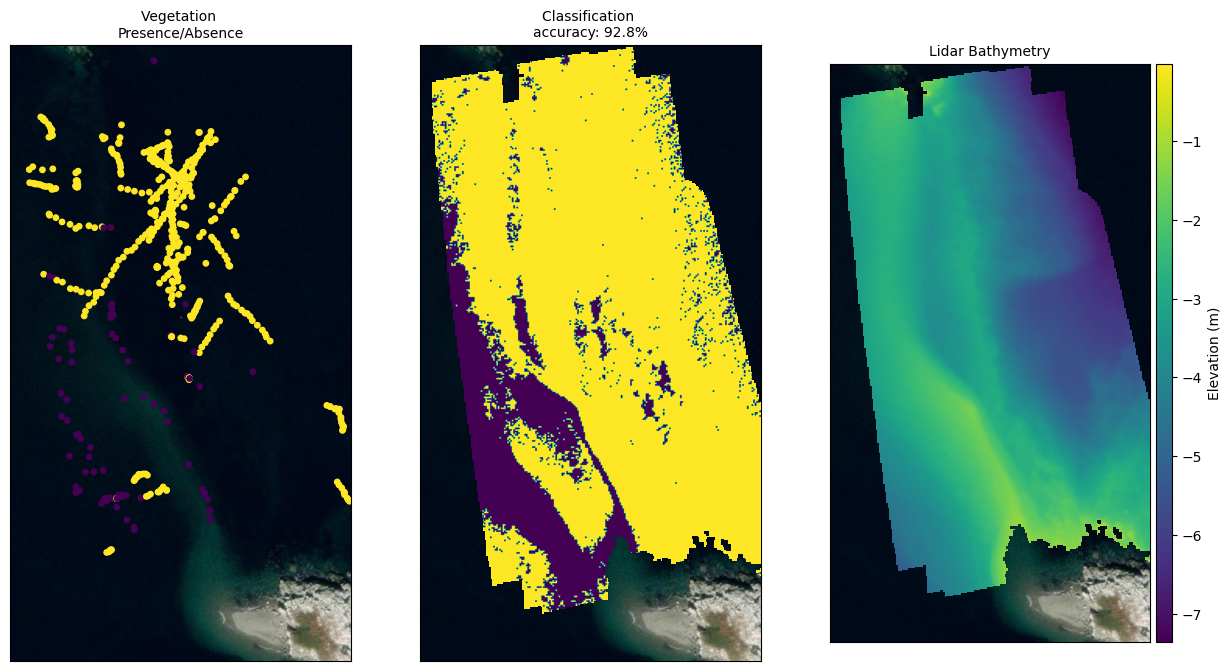

In [1355]:
# See https://github.com/matplotlib/matplotlib/issues/844/

# Now show the classmap next to the image
# set up gamma corrected rgb for plotting

# full spectral resolution
corr_rgb = arr_clean[[114, 75, 25], :, :]


gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

# plot the hyperspectral and rasterized sacfor next to each other

fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(15, 8))

show(gamma_corrected, 
     transform = rio.windows.transform(subset_window, src.transform), 
     ax=ax1)
ax1.set_title('Vegetation \nPresence/Absence',fontsize=10)
sacfor_data.plot(ax=ax1, 
            c=sacfor_data['veg_pres/a'], 
            markersize=15)

ctx.add_basemap(ax1, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)

ax1.set_xticks([])
ax1.set_yticks([])

pred_im = show(pa_veg,
                transform = rio.windows.transform(subset_window, src.transform),
               zorder=10,
                ax=ax2)
im_class = pred_im.get_images()[0]
# sacfor_subset_filt.plot(ax=ax2, 
#              c=sacfor_subset_filt['veg_new_class'], 
#              markersize=15)
ctx.add_basemap(ax2, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax2.set_title(f'Classification \naccuracy: {mean_bacc:.1f}%',fontsize=10)
ax2.set_xticks([])
ax2.set_yticks([])

# resize the colorbar to match the size of ax2
# divider = make_axes_locatable(ax2)
# cax = divider.append_axes("right", 
#                           size="5%", 
#                           pad=0.1)
# cbar = fig.colorbar(im_class, 
#                     cax=cax, 
#                     cmap='viridis')
# cbar.ax.tick_params(labelsize=10)
# #cbar.set_ticks([0,1,2,3,4,5])
# # cbar.set_ticks([0,1,2])
# cbar.set_ticks([0,1])
# cbar.set_label('Cover Class')

rio_im = show(bathy_subset_nanmasked, 
              transform = rio.windows.transform(subset_window, bathy.transform), 
              zorder=10,
              ax=ax3,
              cmap='viridis')
im = rio_im.get_images()[0]
ctx.add_basemap(ax3, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax3.set_title('Lidar Bathymetry',fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')


fig.savefig(f'{veg_out}/final_maps/{runtype}/{datestring}_veg_PA.jpg')
plt.show()

## Kelp Classifier

In [1592]:
# Bare substrate mask
vegmask = pa_veg == 0

# depth mask
depth_mask = (bathy_subset_nanmasked <= 0) & (bathy_subset_nanmasked > -4)

# sidescan mask
sidescan_mask = nanmask_slope+nanmask_rug

# total mask
combined_mask = vegmask | ~depth_mask + sidescan_mask#

# mask everything
bathy_vegmask = np.ma.masked_array(bathy_subset_nanmasked, mask=combined_mask)
slope_vegmask = np.ma.masked_array(slope_subset_nanmasked, mask=combined_mask)
rug_vegmask = np.ma.masked_array(rug_subset_nanmasked, mask=combined_mask)   
gstar_vegmask = np.ma.masked_array(gstar_subset_nanmasked,mask=np.tile(combined_mask, (arr_subset.shape[0], 1, 1)))
arr_subset_vegmask = np.ma.masked_array(arr_subset_nanmasked,mask=np.tile(combined_mask, (arr_subset.shape[0], 1, 1)))

# reshape the 2D arrays to 3D
bathy_reshape = np.reshape(bathy_vegmask,(1,bathy_vegmask.shape[0],bathy_vegmask.shape[1]))
slope_reshape = np.reshape(slope_vegmask,(1,slope_vegmask.shape[0],slope_vegmask.shape[1]))
rug_reshape = np.reshape(rug_vegmask,(1,rug_vegmask.shape[0],rug_vegmask.shape[1]))

### just spectra
# arr_clean = arr_subset_vegmask
# arr_clean = np.ma.vstack((arr_subset_vegmask,gstar_vegmask))

### stack the spectra + bathymetry (for depth)
# arr_clean = np.ma.vstack((arr_subset_vegmask,bathy_reshape))
# arr_clean = np.ma.vstack((arr_subset_vegmask,gstar_vegmask,bathy_reshape))

### stack the spectra + bathymetry + slope + rugosity
# arr_clean = np.ma.vstack((arr_subset_vegmask,bathy_reshape,slope_reshape,rug_reshape))
arr_clean = np.ma.vstack((arr_subset_vegmask,gstar_vegmask,bathy_reshape,slope_reshape,rug_reshape))

In [1593]:
file_str = 'rrs_getisord_z_sidescan'
class_str = 'LMD'
depth_str = 'depth_0_4'

Update sacfor to only include valid data

In [1594]:
# Create a list to store raster values for each point
raster_values = []

# Loop through each point in the GeoDataFrame
for index, point in sacfor_data.iterrows():
    
    # Get the coordinates of the point
    x, y = point['geometry'].x, point['geometry'].y

    # Convert point coordinates to pixel coordinates in the raster
    row, col = src.index(x, y)

    # Extract raster value at the pixel coordinates
    try:
        value = arr_clean[50, row, col]  # Just get one band
    except IndexError:
        value = -9999.0

    # Append the value to the list
    raster_values.append(value)

# Add the extracted values as a new column in the GeoDataFrame
sacfor_data['spectral value'] = raster_values
sacfor_data = sacfor_data[sacfor_data['spectral value'] != src.nodata]

Rasterize new sacfor file

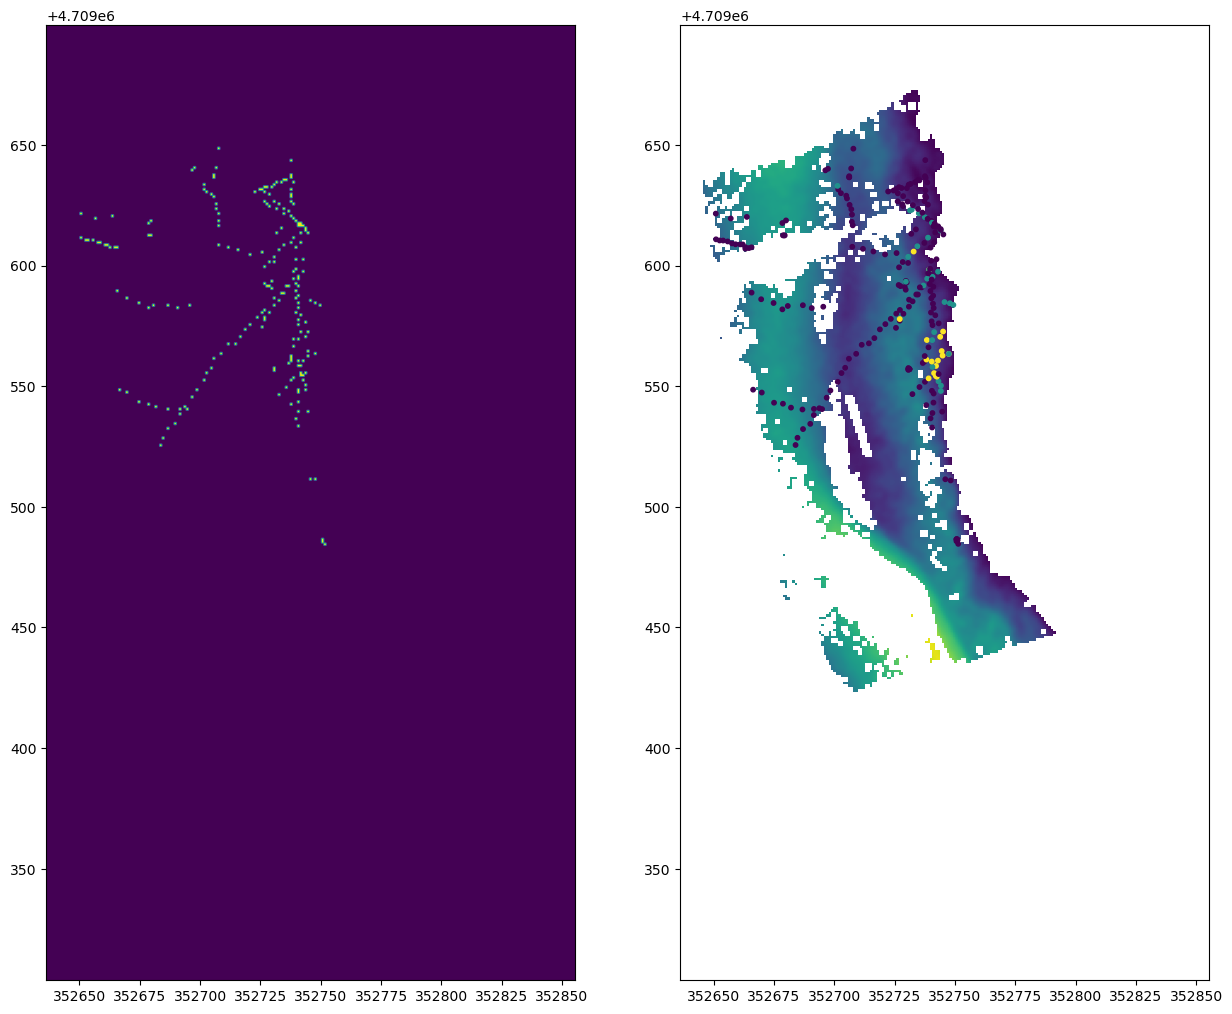

In [1595]:
# rasterize the sacfor gpd to the cropped bounding box based on the 'sacfor_veg target
# as the values in the sacfor raster
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "transform": rio.windows.transform(subset_window, src.transform),
    "dtype": 'int32'
})

sacfor_data = sacfor_data

# Names
sacfor_raster_names = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data.index)],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


sacfor_raster_binkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_pres/'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


sacfor_raster_fewkelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kelp_new_c'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)


# FULL SACFOR 
sacfor_raster_kelp = rio.features.rasterize(
    [(geom, val) for geom, val in zip(sacfor_data.geometry, sacfor_data['kel #'])],
    out_shape=(arr_subset.shape[1], arr_subset.shape[2]),
    transform=out_meta["transform"],
    fill=-9999.0,
    all_touched=True,
    dtype='int32'
)

# Check transforms match up

fig1, (ax1,ax2) = plt.subplots(ncols=2,figsize=(15,15))
     
show(sacfor_raster_names,
     transform = out_meta['transform'],
              ax=ax1)
# s = sacfor_subset.plot(ax=ax1, 
#                             column='kelp_new_class', 
#                             markersize = 10,
#                            edgecolor='k')
                            

show(arr_clean[-3,:,:],
     transform = out_meta['transform'],
              ax=ax2)
s = sacfor_data.plot(ax=ax2, 
                            column='kelp_new_c', 
                            markersize = 10)


Dimensionality Reduction - PCA

In [1596]:
# Convert to 2D numpy array
flattened_data = np.transpose(arr_clean, (1, 2, 0)).reshape(-1, arr_clean.shape[0])

# add bathymetry data onto flattened data

# Perform PCA on the flattened data
pca = PCA(n_components = 50)
pca.fit(flattened_data)

# Transform the data into the PCA space
pca_data_flattened = pca.transform(flattened_data)

# Reshape the PCA data back into its original shape
pca_data = pca_data_flattened.reshape(arr_clean.shape[1], arr_clean.shape[2],-1)

#arr_clean_pca = arr_clean.reshape(arr_clean.shape[1], arr_clean.shape[2],arr_clean.shape[0])
arr_clean_nopca = np.transpose(arr_clean, (1, 2, 0))

# # Save the PCA data to disk
# with rio.open(pca_file, 'w', **meta) as dst:
#     dst.write(pca_data)


Setting up data - Pairing X and y data

In [1597]:
# choose validation data raster (binary, etc)
sacfor_type = sacfor_raster_fewkelp

# set up X and Y
n_samples = (sacfor_type >= 0).sum()
print('We have {n} samples'.format(n=n_samples))

# What are our classification labels?
labels = np.unique(sacfor_type[sacfor_type >= 0])
print('The training data include {n} classes: {classes}'.format(n=labels.size, 
                                                                classes=labels))
           
# get the data (spectra and depth)

raster_data = arr_clean_nopca[sacfor_type >= 0,:]
# raster_data = pca_data[sacfor_type >= 0,:]

# We will need a "X" matrix containing our features, and a "y" array containing our labels
# These will have n_samples rows
X = raster_data

#scale the data
# scaler = MinMaxScaler()
# scaler.fit(X)
# X = scaler.transform(X)

# X with pca only 
# X = pca_data[sacfor_type >= 0,:]

# y
y = sacfor_type[sacfor_type >= 0]


# y removing NaN from depth
# y = sacfor_type[sacfor_type >= 0][~np.isnan(X_all).any(axis=1)]

# get the ID for the names so that it can be added to a results df later
names = sacfor_raster_names[sacfor_type >= 0][~np.isnan(X).any(axis=1)]


# split up the dataset to training and validation

# split up the dataset to training and validation with stratification
train_X, val_X, train_y, val_y, train_names, val_names = train_test_split(
    X, y, names,
    test_size=0.2,
    random_state=1,
    stratify=y  # Ensure stratified split based on 'y'
)
         

print(f'Our X matrix is sized: {X.shape}')
print(f'Our y array is sized: {y.shape}')





We have 213 samples
The training data include 3 classes: [0 1 2]
Our X matrix is sized: (213, 365)
Our y array is sized: (213,)


### K-Folds Cross-validation Balanced Random Forest Model

In [ ]:
# Initialize lists to store results
accuracy_scores = []
balanced_accuracy_scores = []
kappa_scores = []
mean_squared_errors = []
oob_scores = []

# times to repeat k-fold
splits = 5
k_times = 10
tot_runs = splits*k_times

veg_pred = np.ma.masked_array(np.zeros((tot_runs,arr_clean.shape[1],arr_clean.shape[2])),
                              mask = np.tile(nanmask, (tot_runs, 1, 1)))

# Define k-fold cross-validation
k_fold = KFold(n_splits=splits, shuffle=True, random_state=42)

# Repeat 10 times
for k in range(k_times):
    # Perform k-fold cross-validation
    for i, (train_index, val_index) in enumerate(k_fold.split(train_X)):
        # Fit model
        rf = BalancedRandomForestClassifier(bootstrap=True,oob_score=True)
        rf.fit(train_X[train_index], train_y[train_index])
        
        # Predict on validation set
        y_pred_rf = rf.predict(train_X[val_index])
        
        # Calculate metrics
        acc_score = accuracy_score(train_y[val_index], y_pred_rf) * 100
        bacc_score = balanced_accuracy_score(train_y[val_index], y_pred_rf) * 100
        k_score = cohen_kappa_score(train_y[val_index], y_pred_rf)
        mse = mean_squared_error(train_y[val_index], y_pred_rf)
        oob_score = rf.oob_score_ * 100

        # populate lists
        accuracy_scores.append(acc_score)
        balanced_accuracy_scores.append(bacc_score)
        kappa_scores.append(k_score)
        mean_squared_errors.append(mse)
        oob_scores.append(oob_score)

        # predict the class for each pixel
        pred = rf.predict(flattened_data)
        # pred = rf.predict(pca_data_flattened)
        pred_reshape = pred.reshape(arr_clean[0,:, :].shape)
        pred_mask = np.ma.masked_array(pred_reshape, mask=np.tile(nanmask+combined_mask, (1, 1, 1)))

        # Save predictions to veg_pred
        start_index = k * splits
        veg_pred[start_index+i, :, :] = pred_mask      

        # plot a figure for each k-fold run
        
        fig,(ax1,ax2) = plt.subplots(1,2, figsize = (10,10))
        # Cross-tabulate predictions
        cm = ConfusionMatrixDisplay.from_estimator(rf, val_X, val_y,ax=ax1,colorbar=False)
        cm.ax_.set_title(f'Balanced Accuracy Score: {bacc_score:.1f}%'+f'\nMSE: {mse:.2f}')
        
        ax2.imshow(pred_mask,cmap='tab20b')

        fig.savefig(f'{kelp_out}kfold_runs/{runtype}/{class_str}/{depth_str}/{datestring}_{file_str}_kfold_run{start_index+i+1}.png')
        plt.show()
        


In [1599]:
# Print average results from k-fold cross validation runs
mean_oob = sum(oob_scores) / len(oob_scores)
mean_acc = sum(accuracy_scores) / len(accuracy_scores)
mean_bacc = sum(balanced_accuracy_scores) / len(balanced_accuracy_scores)
mean_kappa = sum(kappa_scores) / len(kappa_scores)
mean_mse = sum(mean_squared_errors) / len(mean_squared_errors)

print(f'Average OOB: {mean_oob:.2f}%')
print(f'Average Accuracy Score: {mean_acc:.2f}%')
print(f'Average Balanced Accuracy Score: {mean_bacc:.2f}%')
print(f'Average Kappa Score: {mean_kappa:.2f}')
print(f'Average MSE: {mean_mse:.2f}')

Average OOB: 60.56%
Average Accuracy Score: 60.65%
Average Balanced Accuracy Score: 70.87%
Average Kappa Score: 0.27
Average MSE: 0.76


#### Final Maps for Binary Classification

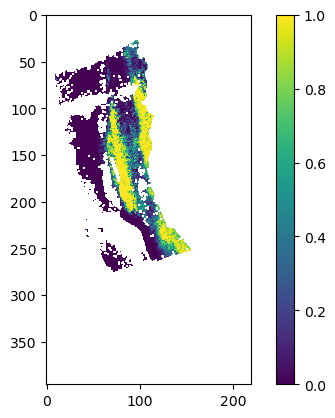

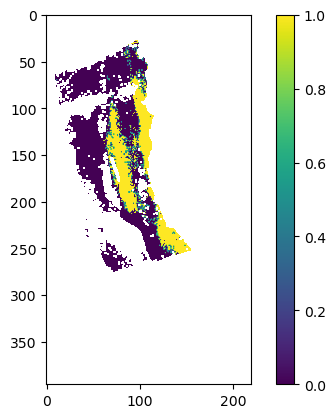

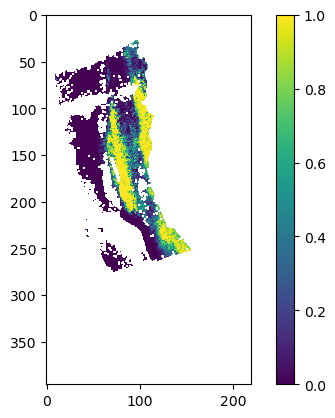

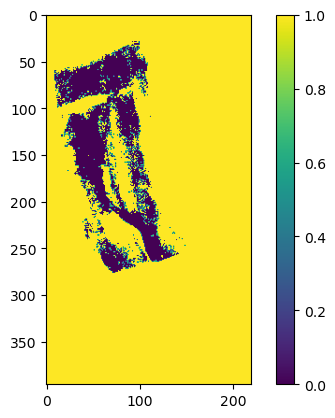

In [1475]:
# Final maps

# Calculate Probability for binary class
prob_kelp = sum(veg_pred)/tot_runs
prob_kelp = prob_kelp.reshape(1, prob_kelp.shape[0],prob_kelp.shape[1])
plt.imshow(prob_kelp[0,:,:])
plt.colorbar()
plt.show()

# Calculate Classification for binary class
class_kelp = prob_kelp > 0.5
class_kelp = np.ma.masked_array(class_kelp, mask=nanmask)
plt.imshow(class_kelp[0,:,:])
plt.colorbar()
plt.show()

# set the metadata for the rasters
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "count": 1,
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

# save probability raster
outfile = f'{kelp_out}final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp_probability.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(prob_kelp)

with rio.open(outfile) as data:
    d = data.read(masked=True)

plt.imshow(d[0,:,:])
plt.colorbar()
plt.show()

# save presence/absence raster
outfile = f'{kelp_out}final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp_classification.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(class_kelp)

with rio.open(outfile) as data:
    d = data.read(masked=True)

plt.imshow(d[0,:,:])
plt.colorbar()
plt.show()


#### Final Maps for multiclass classification

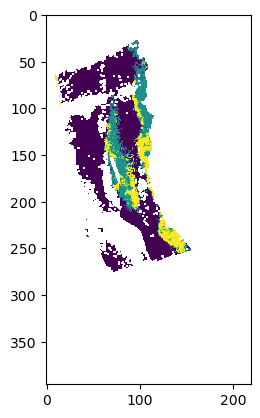

In [1600]:
# Calculate probalities for multiclass

# Class zero
prob_zero = sum(veg_pred == 0)/tot_runs
prob_zero = prob_zero.reshape(1, prob_zero.shape[0],prob_zero.shape[1])
# Class one
prob_one = sum(veg_pred ==1)/tot_runs
prob_one = prob_one.reshape(1, prob_one.shape[0],prob_one.shape[1])
# Class two
prob_two = sum(veg_pred ==2)/tot_runs
prob_two = prob_two.reshape(1, prob_two.shape[0],prob_two.shape[1])

prob_stack = np.ma.stack((prob_zero,prob_one,prob_two))

# get the classification for each pixel based on the highest probability
class_kelp = np.ma.argmax(prob_stack,axis=0)
class_kelp = np.ma.masked_array(class_kelp,mask = nanmask+combined_mask)
plt.imshow(class_kelp[0,:,:])



Save rasters for multiclass problem

In [1601]:
# set the metadata for the rasters
out_meta = src.meta.copy()
out_meta.update({
    "height": arr_subset.shape[1],
    "width": arr_subset.shape[2],
    "count": 1,
    "transform": rio.windows.transform(subset_window, src.transform),
    "nodata": -9999.0
})

# # save probability rasters
outfile = f'{kelp_out}final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp_probability_zero.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(prob_zero)

outfile = f'{kelp_out}final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp_probability_one.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(prob_one)

outfile = f'{kelp_out}final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp_probability_two.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(prob_two)


# save kelp classification
outfile = f'{kelp_out}final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp_classification.tif'
with rio.open(outfile, 'w', **out_meta) as dst:
    dst.write(class_kelp)

### Predicting the rest of the image

In [1602]:
# mask bare substrate
kelp_prediction_mask = np.ma.masked_array(class_kelp, mask=nanmask + combined_mask)

# mask deep water
# kelp_prediction_mask = np.ma.masked_array(kelp_prediction_reshape, mask=zmask)

# # mask missing sidescan data
# kelp_prediction_mask = np.ma.masked_array(kelp_prediction_mask, mask=np.tile(nanmask_slope, (1,1,1)))
# kelp_prediction_mask = np.ma.masked_array(kelp_prediction_mask, mask=np.tile(nanmask_rug, (1,1,1)))

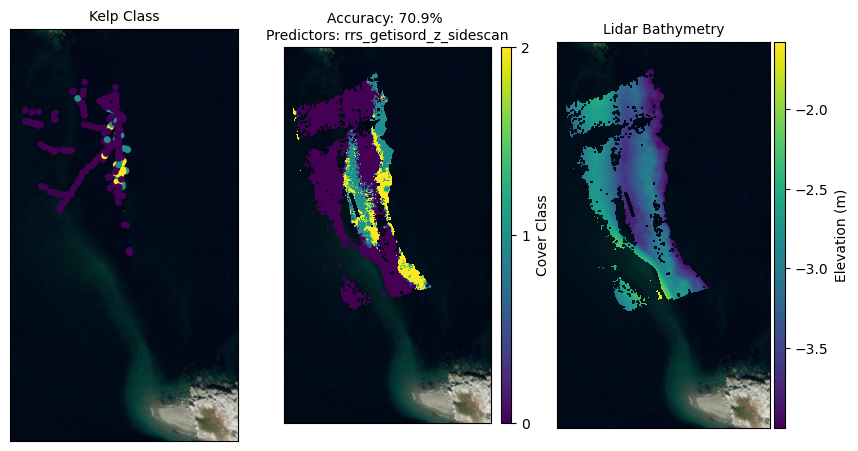

In [1603]:
# See https://github.com/matplotlib/matplotlib/issues/844/

# Now show the classmap next to the image
# set up gamma corrected rgb for plotting

# full spectral resolution
corr_rgb = arr_subset_nanmasked[[114, 75, 25], :, :]


gamma_corrected = exposure.adjust_gamma(corr_rgb, gamma=0.23)

# plot the hyperspectral and rasterized sacfor next to each other

fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, figsize=(10, 8))

show(gamma_corrected, 
     transform = rio.windows.transform(subset_window, src.transform), 
     ax=ax1)
ctx.add_basemap(ax1, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax1.set_title('Kelp Class',fontsize=10)
sacfor_data.plot(ax=ax1, 
                        c=sacfor_data['kelp_new_c'], 
                        markersize=15)
ax1.set_xticks([])
ax1.set_yticks([])

pred_im = show(kelp_prediction_mask,
                transform = rio.windows.transform(subset_window, src.transform),
                ax=ax2,
              zorder = 21)
im_class = pred_im.get_images()[0]
ctx.add_basemap(ax2, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax2.set_title(f'Accuracy: {mean_bacc:.1f}% \nPredictors: {file_str}',fontsize=10)
ax2.set_xticks([])
ax2.set_yticks([])

# resize the colorbar to match the size of ax2
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad=0.1)
cbar = fig.colorbar(im_class, 
                    cax=cax, 
                    cmap='viridis')
cbar.ax.tick_params(labelsize=10)
# #cbar.set_ticks([0,1,2,3,4,5])
cbar.set_ticks([0,1,2])
# cbar.set_ticks([0,1])
cbar.set_label('Cover Class')

rio_im = show(bathy_vegmask, 
              transform = rio.windows.transform(subset_window, bathy.transform), 
              ax=ax3,
              cmap='viridis',
             zorder = 21)
im = rio_im.get_images()[0]
ctx.add_basemap(ax3, 
                crs=sacfor_data.crs, 
                source=ctx.providers.Esri.WorldImagery,
               attribution=False)
ax3.set_title('Lidar Bathymetry',fontsize=10)
ax3.set_xticks([])
ax3.set_yticks([])

divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", 
                          size="5%", 
                          pad='2%')
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Elevation (m)')


fig.savefig(f'output/cross_validation_runs/kelp/final_maps/{runtype}/{class_str}/{depth_str}/{datestring}_{class_str}_{file_str}_kelp.jpg')
plt.show()